In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import cross_val_predict
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import f_classif
from sklearn.metrics import f1_score
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
from sklearn.metrics import recall_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
from joblib import dump, load
from tqdm import tqdm  # Import tqdm for the progress bar
import random

**Please read the Bagging section first!**

### 3. Boosting
In this section we are going to implement Boosting: Weak learners are trained sequentially in a way that each learner tries to fix the errors of the previous one and at the end a strong learner combines the weak learners to make a final predcition. There are 5 types of Boosting algortihms:
- **Gradient Tree Boosting**: it uses trees as weak learners using gradient descent.
- **AdaBoost**: fits weak learners sequentially, giving more weight to correct predictions annd less weight to correct predictions and the final predicitons are obtained by majority.
-**XGBoost**: it is a regularized version of Gradient Tree Boostin, which tends to be faster and more accurate
- **CatBoost**: Is specially effective in categorical datasets which creates symmetric decision trees.
- **Light GBM**: It creates trees in away that only one leaf is grown form each tree.It also works well on categorical datasets.

We decided to implement the most simple version (Gradient Tree Boosting) using Python sckit-learn.

#### 3.1 Read Data

Same as Bagging.

In [ ]:
x = pd.read_csv('TCGAdata.txt', sep=" ", header= 0) #files separated by "" and first column=header

y = pd.read_csv('TCGAlabels.txt',header=0, sep=" ",index_col=0)
y=y["x"]


print("Number of nulls in features:", sum(x.isnull().sum())) # No nulls
print("Number of nulls in labels:", y.isnull().sum())

Number of nulls in features: 0
Number of nulls in labels: 0


In [ ]:
#join x and y
z=x.join(y)
groups=z.groupby("x")

mean=groups.mean()
var=groups.var()

#### 3.2 Best Parameters

Again, we estimate the best parameters for 0 noise data and generalize for all the types of noise.

In [ ]:
#this cell to show to run the code to find  best parameters for gradient boooting
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

z= np.load(f'dataset_0.0.npy', allow_pickle=True)
x,y = z[:,:-1],z[:,-1]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20)

# Initialize GradientBoostingClassifier
gradient_boosting_clf = GradientBoostingClassifier()

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [5, 10, 15],
    'max_depth': [3, 5, 7],
}

# Initialize GridSearchCV with parallel processing
grid_search = GridSearchCV(gradient_boosting_clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

# Assuming X_train and y_train are already defined and available
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Parameters: {'max_depth': 3, 'n_estimators': 15}
Best Score: 0.9761810857255544


In this case we need to get `max_depth`, that is the max depth of the trees, and `n_estimators`that as in Bagging of Random Forests, is the number of weak learners used in the ensemble. For the max depth we got 3, meaning that is better to implement shallow trees, whereas for the number of estimators we still the maximum number.

#### 3.3 Training each level of noise

We trained the Gradient Boosting Classifier for each level of noise using the best parameters, and used recall as the main evaluation metric.

      Iter       Train Loss   Remaining Time 
         1           1.0586            2.26m
         2           0.8441            1.99m
         3           0.6893            1.70m
         4           0.5708            1.45m
         5           0.4768            1.20m
         6           0.4013           57.30s
         7           0.3397           42.74s
         8           0.2890           28.38s
         9           0.2461           14.14s
        10           0.2111            0.00s
Recall at noise level 0.00% : 0.9810
      Iter       Train Loss   Remaining Time 
         1           1.2267            2.38m
         2           1.0243            2.10m
         3           0.8736            1.84m
         4           0.7588            1.59m
         5           0.6683            1.33m
         6           0.5948            1.06m
         7           0.5306           47.91s
         8           0.4782           32.22s
         9           0.4332           16.22s
        10      

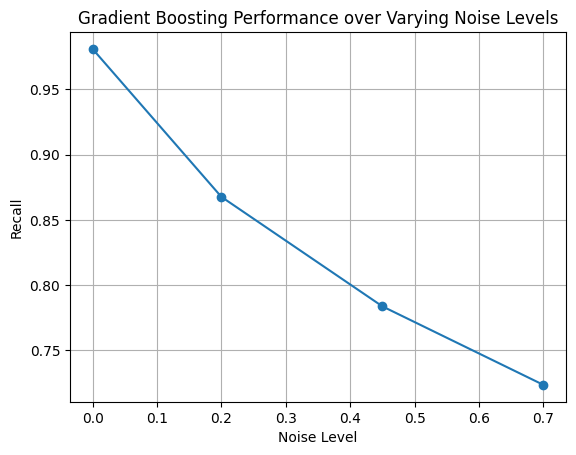

In [ ]:
noise = np.array([0,0.20,0.45,0.70])
accuracy_list = []
for i,level in enumerate (noise):
    # noisy_data = add_noise(data, level)
    # x, y = noisy_data.iloc[:, :-1], noisy_data.iloc[:, -1]
    z= np.load(f'dataset_{noise[i]}.npy', allow_pickle=True)
    x,y = z[:,:-1],z[:,-1]
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20)
    # Define the gradient boosting classifier with verbosity
    gradient_booster = GradientBoostingClassifier(n_estimators=10, random_state=42, verbose=2)

    # Train the model
    gradient_booster.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = gradient_booster.predict(X_test)

    # Evaluate the performance of the model
    recall = recall_score(y_test, y_pred, average='weighted')
    print(f"Recall at noise level {level*100:.2f}% : {recall:.4f}")
    accuracy_list.append(recall)

# Plotting the recall vs. noise level
plt.plot(noise, accuracy_list, marker='o')
plt.title('Gradient Boosting Performance over Varying Noise Levels')
plt.xlabel('Noise Level')
plt.ylabel('Recall')
plt.grid(True)
plt.show()





The recall at the 0 noise level is at the 98% level, almost identical to the results obtained for Baggin. Similarly, de recall decreases linearly with the level of noise.

#### 3.4 Permutation Importance

We already explored in depth the different feature selection methods and how permutation importance worked, therefore here we just focus on the results.

Igonore the plots in upcoming cell as it plots the "raw" important feature results, but in the next section we present it in an interpretable way.

Processing datasets:   0%|          | 0/4 [00:00<?, ?it/s]

Training the model...0
Making predictions...
Accuracy: 0.967128027681661
Computing permutation importance...
Plotting feature importance...


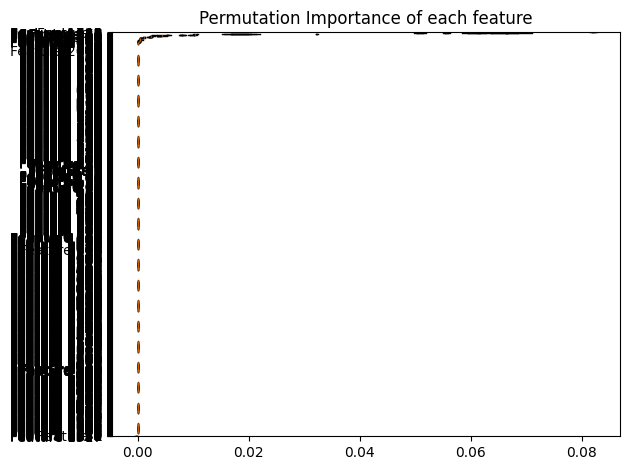

Processing datasets:  25%|██▌       | 1/4 [11:02<33:06, 662.25s/it]

Training the model...1
Making predictions...
Accuracy: 0.8340943683409436
Computing permutation importance...
Plotting feature importance...


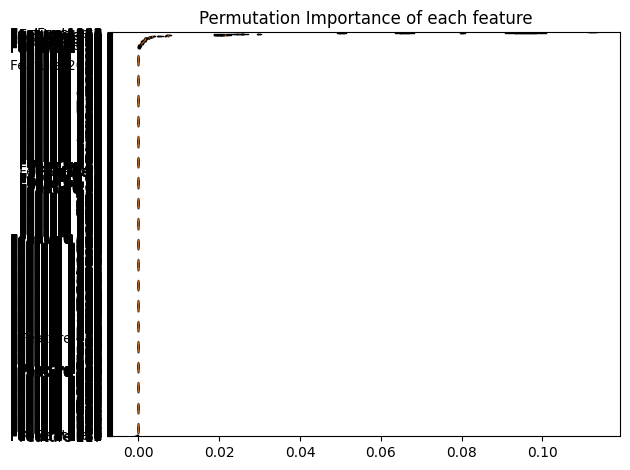

Processing datasets:  50%|█████     | 2/4 [22:07<22:08, 664.24s/it]

Training the model...2
Making predictions...
Accuracy: 0.7783641160949868
Computing permutation importance...
Plotting feature importance...


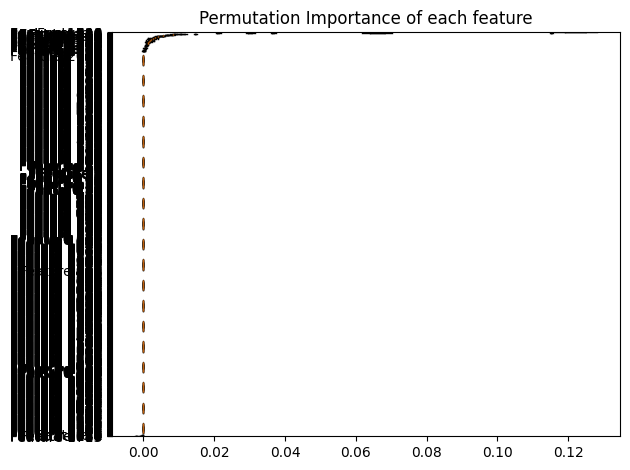

Processing datasets:  75%|███████▌  | 3/4 [31:46<10:24, 624.96s/it]

Training the model...3
Making predictions...
Accuracy: 0.6861143523920653
Computing permutation importance...
Plotting feature importance...


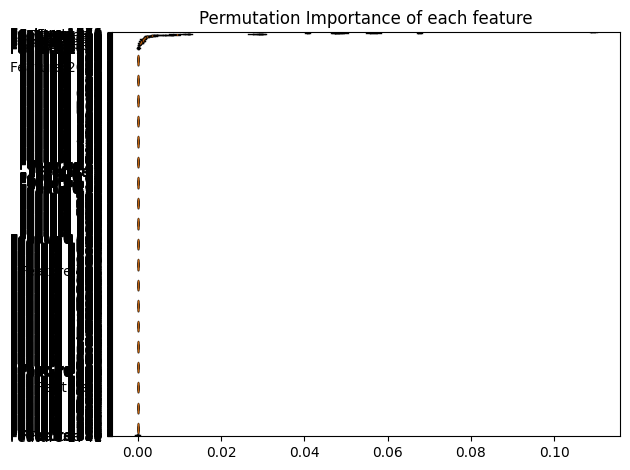

Processing datasets: 100%|██████████| 4/4 [42:41<00:00, 640.33s/it]


In [ ]:
for i in tqdm(range(0, len(noise)), desc="Processing datasets"):
    z = np.load(f'dataset_{noise[i]}.npy', allow_pickle=True)
    x, y = z[:, :-1], z[:, -1]
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20)

    # Use Gradient Boosting Classifier
    print(f"Training the model...{i}")
    gradient_boosting_classifier = GradientBoostingClassifier(n_estimators=5, random_state=42)
    gradient_boosting_classifier.fit(X_train, y_train)

    # Prediction
    print("Making predictions...")
    y_pred = gradient_boosting_classifier.predict(X_test)

    # Evaluate the performance
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

    # Compute permutation importance
    print("Computing permutation importance...")
    result = permutation_importance(gradient_boosting_classifier, X_train, y_train, n_repeats=2, random_state=42, n_jobs=-1)
    dump(result, rf'C:\Users\purus\Documents\Chalmers\Big_data\hw2\results\Gradient_boosting/permutation_gradientBoosting_importance_result_{noise[i]}.joblib')
    loadedresult = load(rf'C:\Users\purus\Documents\Chalmers\Big_data\hw2\results\Gradient_boosting/permutation_gradientBoosting_importance_result_{noise[i]}.joblib')

    # Plotting permutation importances
    print("Plotting feature importance...")
    feature_names = [f"Feature {i+1}" for i in range(X_train.shape[1])]  # Assuming you don't have feature names
    sorted_idx = result.importances_mean.argsort()
    plt.figure()
    plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=[feature_names[i] for i in sorted_idx])
    plt.title("Permutation Importance of each feature")
    plt.tight_layout()
    plt.show()


Now we show the permutation results in an understandable way.

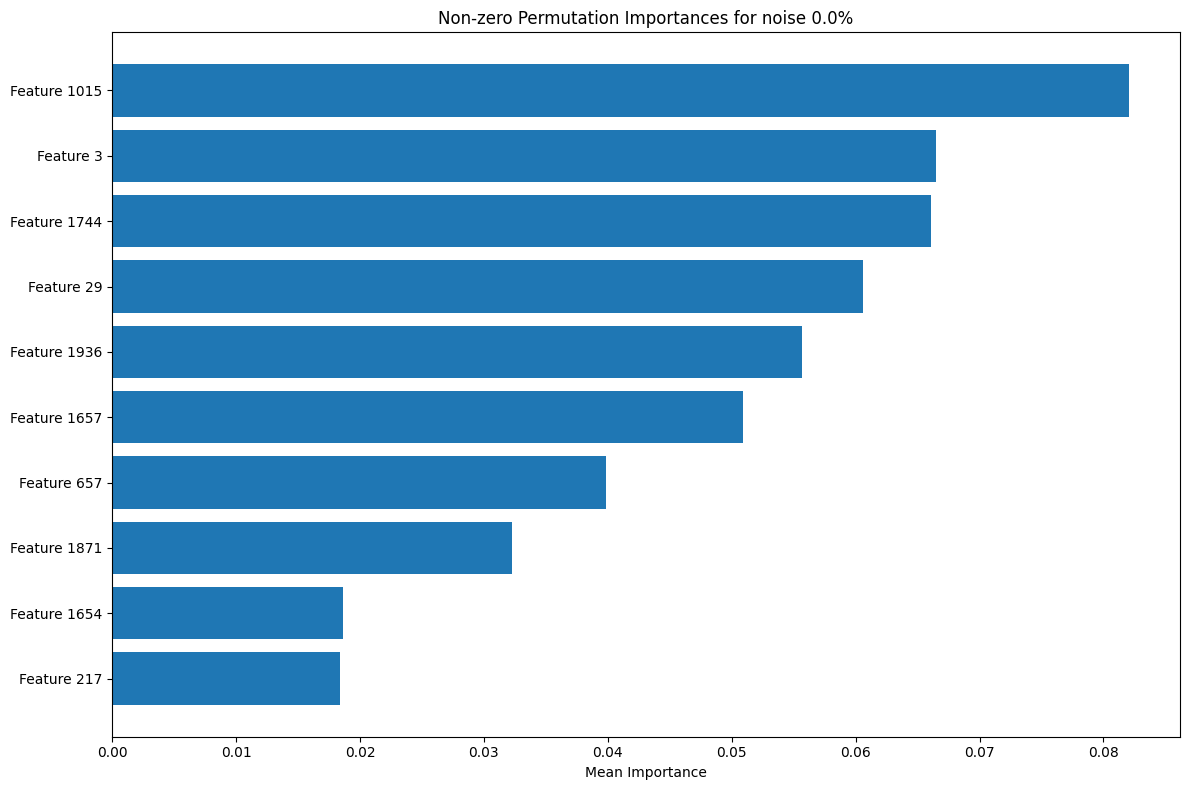

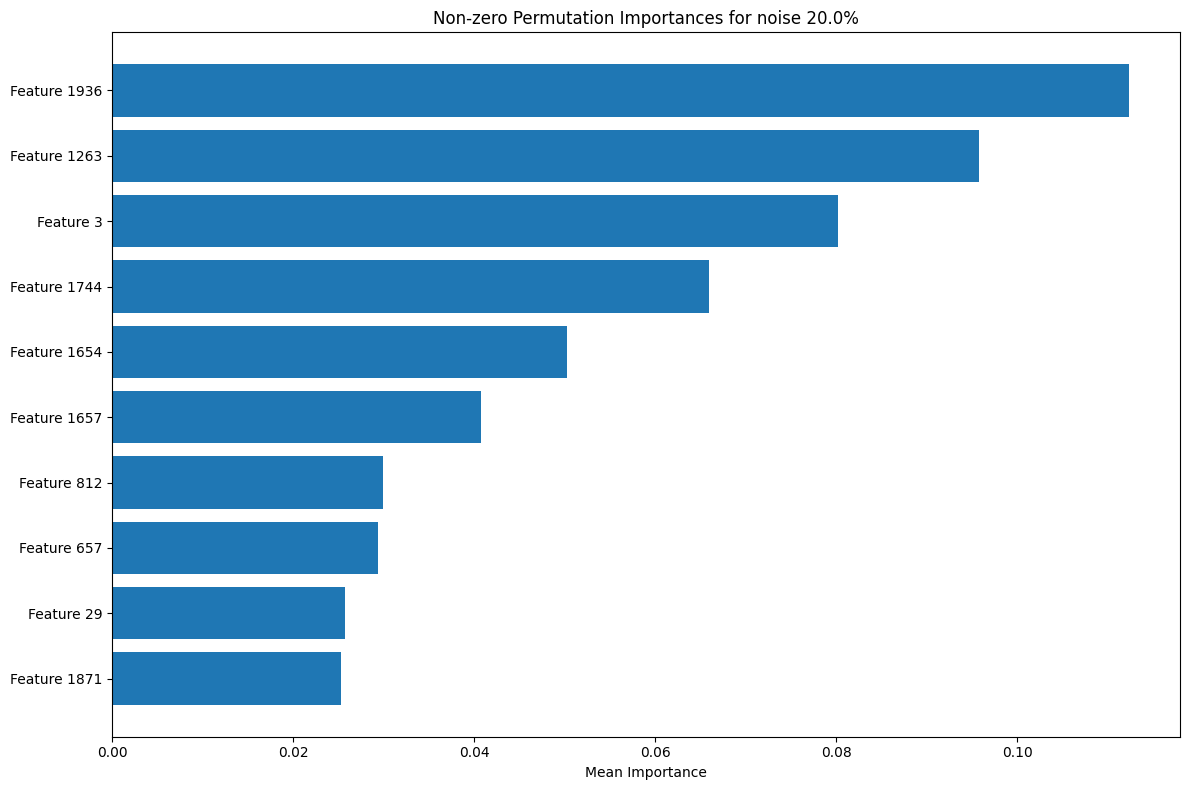

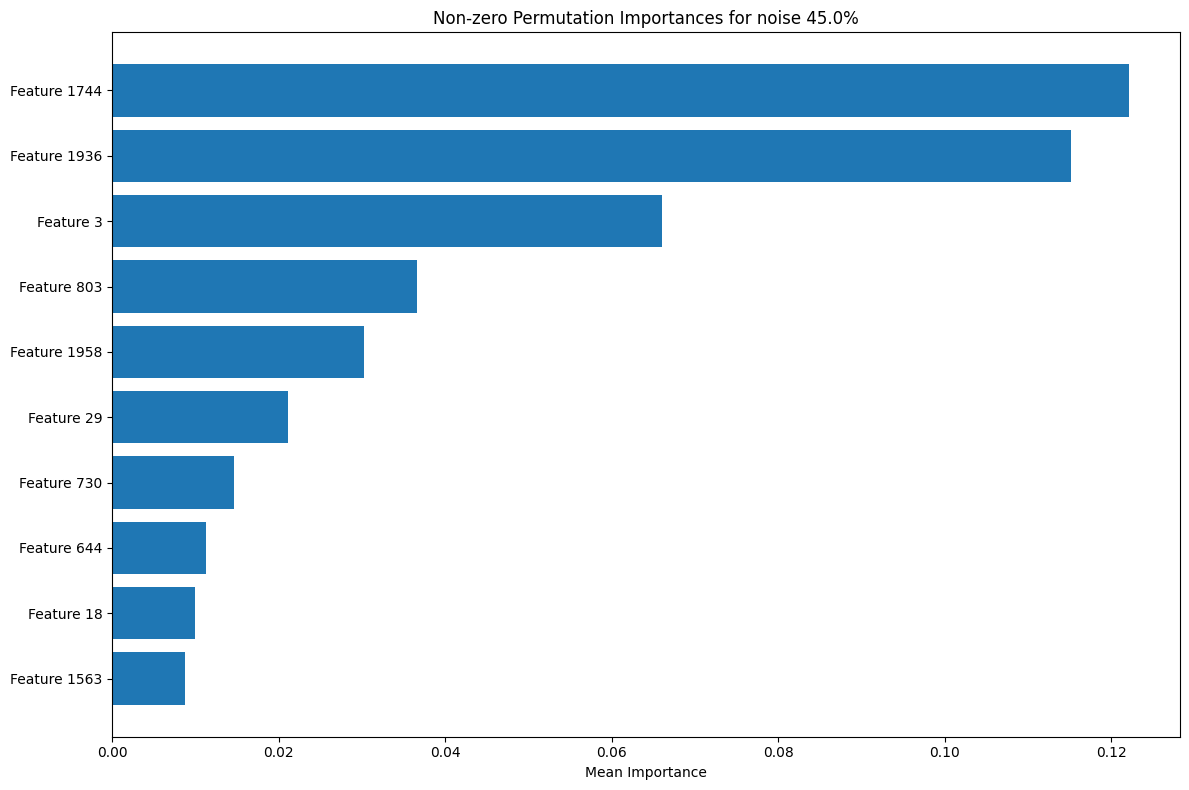

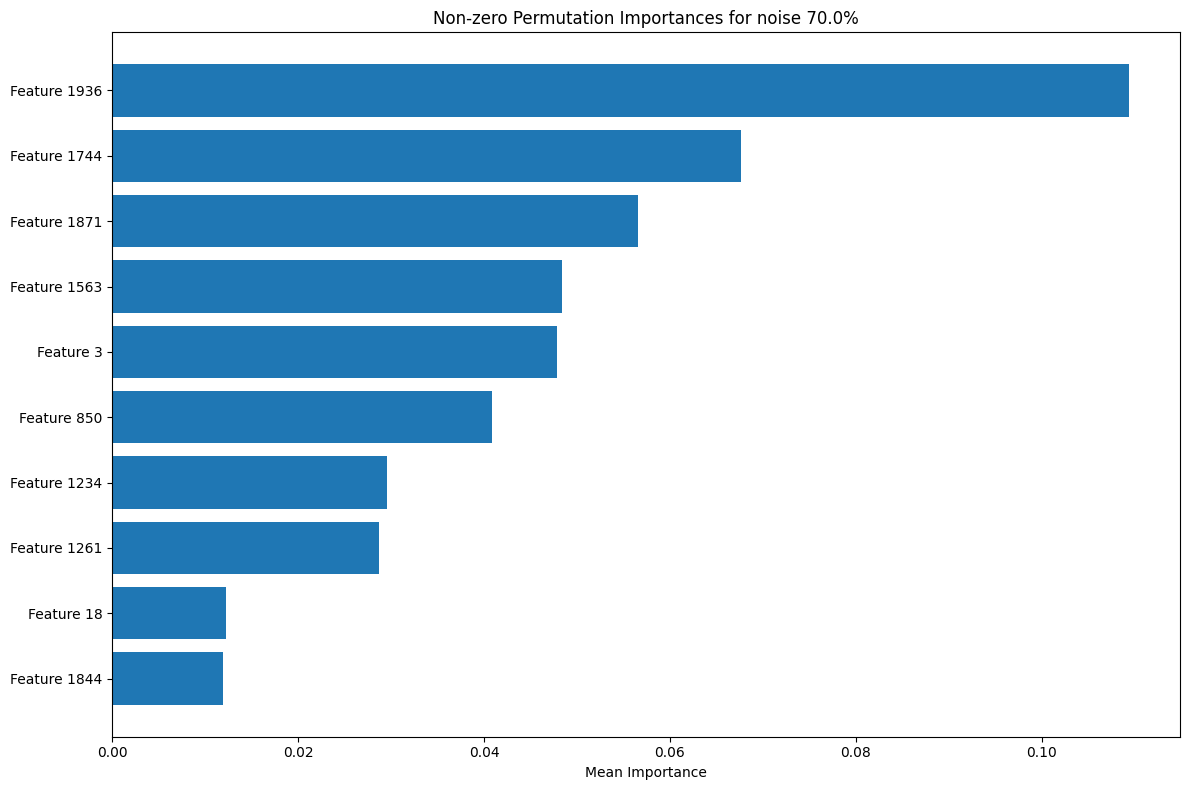

[50, 81, 100, 90]


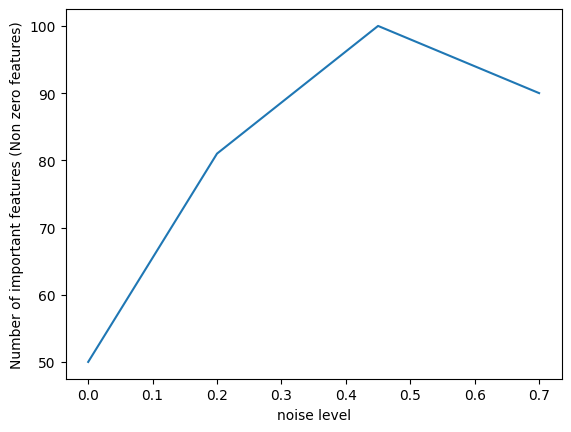

In [ ]:
noise = np.array([0,0.20,0.45,0.70])
number_of_important_features = []
for i in range (len(noise)):
    loadedresult= load(rf'/content/permutation_gradientBoosting_importance_result_{noise[i]}.joblib')
    importance_means = loadedresult.importances_mean[0]

    non_zero_indices = np.where(loadedresult.importances_mean != 0)[0]
    non_zero_importances = loadedresult.importances_mean[non_zero_indices]

    #get the indexes of top N important features sorted by absolute value
    n = 10  # Number of values you want to keep
    # Get the indices of elements sorted by absolute values in descending order
    sorted_abs_indices = np.argsort(np.abs(non_zero_importances))[::-1]
    # Get the top n indices
    top_n_indices = sorted_abs_indices[:n]
    # Sort the top n indices by the original values
    sorted_indices = np.argsort(non_zero_importances[top_n_indices])[::-1]
    # Get the indices of the top n elements with highest absolute values
    sorted_idx = top_n_indices[sorted_indices][::-1]

    # Filter feature names for non-zero importances
    non_zero_feature_names = [f"Feature {i+1}" for i in non_zero_indices]
    number_of_important_features.append(len(non_zero_feature_names))

    # Plot
    plt.figure(figsize=(12, 8))
    plt.barh(range(len(sorted_idx)), non_zero_importances[sorted_idx], align='center')
    plt.yticks(range(len(sorted_idx)), [non_zero_feature_names[i] for i in sorted_idx])
    plt.xlabel('Mean Importance')
    plt.title(f'Non-zero Permutation Importances for noise {noise[i]*100}%')
    plt.tight_layout()
    plt.show()

print(number_of_important_features)
plt.plot(noise,number_of_important_features)
plt.xlabel('noise level')
plt.ylabel('Number of important features (Non zero features)')
plt.show()


Top 10 features for:
- 0 noise: **3**, **1744**, **29**,**1936**, **1657**, **657**,**1871**, **1654**, 217
- 20% noise: **3**, **1744**, **1654**, **1657**, 812, 657, **29**,**1871**
- 45% noise: **1744**, **1936**, **3**, 803, 1958,**29**, 730, 644, 18
- 70% noise: **1936**, **1744**, 1871, 1563, **3**, 850, 1234, 1261, 18

Using Bagging of RandomForests the top 10 important features were not consistent among different levels of noise, and it could be that 10 features at the level of noise was not enough to achieve consistency. Howeve, Boosting Trees proved that hypothesis wrong and show a decent amount of consistency even when the noise at a 70%.
Again, considering de 0 noise features as the real top 10 features, we can see that all the noisy features agree on the importance of many of the features, and if not, the top 10 feature will be included in at least one of the rankings, as there is only one feature that does not appear in any of the rankings . Given that top 10 means 0.5% of the features, wecan say that in this case we obtained very consistent results.

**Common Features between bagging and boosting**

inally, we explored the top features between Bagging and Boosting. As our assumptions is that 0 noise contains the actual top 10 features and our purpose is to compare between models, we will only compare features predicted at a 0 level noise.



In [ ]:
rf_result = load(r"C:\Users\purus\Documents\Chalmers\Big_data\hw2\results\bagging_permutation\permutation_importance_result_0.0.joblib")
gb_result = load(r"C:\Users\purus\Documents\Chalmers\Big_data\hw2\results\Gradient_boosting\permutation_gradientBoosting_importance_result_0.0.joblib")

In [ ]:
feature_names = [f"Feature {i}" for i in range(1,len(X_test[1])+1)]
threshold = np.percentile(gb_result.importances_mean, 75)  # top 25% features as important
important_gb_features = [feature_names[i] for i in np.where(gb_result.importances_mean > threshold)[0]]
important_rf_features = [feature_names[i] for i in np.where(rf_result.importances_mean > threshold)[0]]
# Find common important features
common_important_features = set(important_gb_features).intersection(set(important_rf_features))
print("Common important features:", common_important_features)

Common important features: {'Feature 29', 'Feature 3', 'Feature 1871', 'Feature 1936', 'Feature 1654'}


To conclude, we observe that both models agree on Features 3 and 1871 as in the Top 10 features. Morover, when considering 25% features, both models also agree on Feature 29, 1936 and 1654, which is surpringsily low, as they already agreed on 2 of the 5 common features in the top 10 (which is 0.5% of the features).

We can also conclude that both models provide similar level of results when predicting, but Boosting seems to be much more consistent when selecting features, and therefore more trustworthy (apriori).